<a href="https://colab.research.google.com/github/shradhautk/AI-MICROSCOPY-WORKSHOP/blob/main/DL_for_Microscopy_Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL for Microscopy: Mask R-CNN 
Prepared by Tommy Wong, with sections adapted from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html


**To run this notebook, click Runtime -> Run all, and in Change runtime type slect a GPU. Make sure to specify filenames and uncomment cells according to instructions.**

---

Import modules:

In [1]:
#!pip3 install --upgrade torch torchvision
!pip3 install torch==1.13.0
!pip3 install torchvision==0.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.

Import modules:

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os
from google.colab import files, drive
import torch
import torch.utils.data

In [3]:
#%%shell

#pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
#pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for He Bubbles

Let's write a dataset for the He Bubbles dataset.

In [4]:
# Training data
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_mrcnn_train_imgs.npy'
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_mrcnn_train_labs.pickle'
# Testing data
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/test_image.png'
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/test_label.png'

--2023-06-06 14:05:53--  https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_mrcnn_train_imgs.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9437312 (9.0M) [application/octet-stream]
Saving to: ‘DL_for_Microscopy_mrcnn_train_imgs.npy’

DL_for_Microscopy_m 100%[===================>]   9.00M  --.-KB/s    in 0.05s   

2023-06-06 14:05:54 (179 MB/s) - ‘DL_for_Microscopy_mrcnn_train_imgs.npy’ saved [9437312/9437312]

--2023-06-06 14:05:54--  https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_mrcnn_train_labs.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185

Load data:

In [7]:
# train data
train_images = np.load('DL_for_Microscopy_mrcnn_train_imgs.npy')
labels_dict_file = open('DL_for_Microscopy_mrcnn_train_labs.pickle', 'rb')
labels_dict = pickle.load(labels_dict_file)
labels_dict_file.close()

# test data
test_image = plt.imread('test_image.png')

Sample training image:

1.0

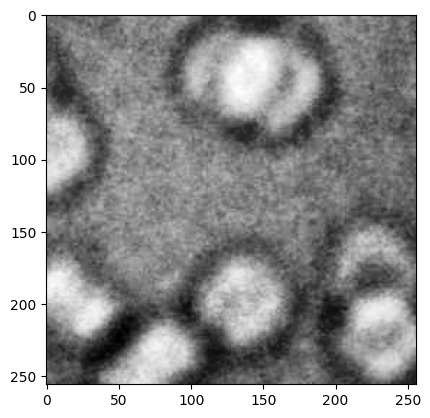

In [8]:
plt.imshow(train_images[0], cmap='gist_gray')
train_images[0].max()

Sample training mask:

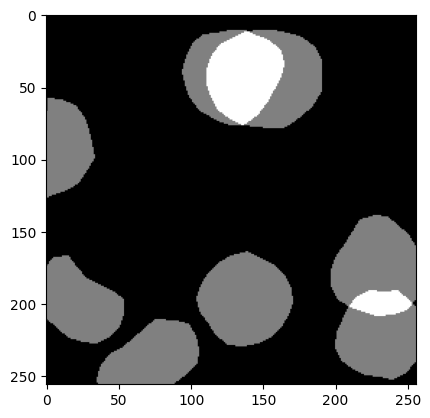

In [9]:
mask = np.sum(labels_dict[0]['masks'].numpy(), axis=0)
plt.imshow(mask, cmap='gist_gray')

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [10]:
class BubbleDataset(torch.utils.data.Dataset):
    def __init__(self, transforms=None):
        self.transforms = transforms
        # load all image files
        self.imgs = train_images
        self.labels_dict = labels_dict

    def __getitem__(self, idx):
        # load images and masks, image has to be PIL
        img = Image.fromarray(np.uint8(self.imgs[idx]/np.max(self.imgs[idx])*255))
        masks = self.labels_dict[idx]['masks']

        # get bounding box coordinates for each mask
        boxes = self.labels_dict[idx]['boxes']

        num_objs = len(self.labels_dict[idx]['labels'])
        
        labels =  self.labels_dict[idx]['labels']

        image_id = torch.tensor([idx])
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [11]:
dataset = BubbleDataset()
dataset[0]

(<PIL.Image.Image image mode=L size=256x256 at 0x7F884A180A00>,
 {'boxes': tensor([[111.,  11., 190.,  78.],
          [ 94.,  11., 164.,  76.],
          [  0.,  58.,  33., 126.],
          [104., 164., 170., 229.],
          [  0., 167.,  53., 227.],
          [ 35., 211., 105., 255.],
          [200., 191., 255., 252.],
          [197., 139., 255., 208.]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

### An Instance segmentation model for He Bubble Dataset

Optionally, we can fine-tune from a pre-trained model, given that our dataset is very small.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_instance_segmentation_model(hidden_layer=32, num_classes=2):
    # load an instance segmentation model pre-trained on COCO
    # v2 is a newer version
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [13]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 335868, done.
remote: Counting objects: 100% (70967/70967), done.
remote: Compressing objects: 100% (1205/1205), done.
remote: Total 335868 (delta 70327), reused 70259 (delta 69736), pack-reused 264901
Receiving objects: 100% (335868/335868), 676.48 MiB | 19.25 MiB/s, done.
Resolving deltas: 100% (309306/309306), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [14]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Train the model

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [15]:
# use our dataset and defined transformations
dataset = BubbleDataset(get_transform(train=True))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# no. of hidden layers
hidden_layer = 32

# get the model using our helper function
model = get_instance_segmentation_model(hidden_layer)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth


  0%|          | 0.00/177M [00:00<?, ?B/s]

And now let's train the model, evaluating at the end of every epoch.

In [17]:
# Define no. of epochs:
from torch.optim.lr_scheduler import StepLR
num_epochs = 50

# Name of model to be saved

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()

Epoch: [0]  [0/9]  eta: 0:00:34  lr: 0.000126  loss: 2.2402 (2.2402)  loss_classifier: 0.6743 (0.6743)  loss_box_reg: 0.2981 (0.2981)  loss_mask: 0.7126 (0.7126)  loss_objectness: 0.4777 (0.4777)  loss_rpn_box_reg: 0.0776 (0.0776)  time: 3.8749  data: 0.1517  max mem: 3799
Epoch: [0]  [8/9]  eta: 0:00:00  lr: 0.001000  loss: 1.8643 (1.6003)  loss_classifier: 0.4571 (0.4133)  loss_box_reg: 0.4204 (0.5061)  loss_mask: 0.3811 (0.4075)  loss_objectness: 0.1509 (0.2192)  loss_rpn_box_reg: 0.0454 (0.0541)  time: 0.6324  data: 0.0231  max mem: 4266
Epoch: [0] Total time: 0:00:05 (0.6378 s / it)
Epoch: [1]  [0/9]  eta: 0:00:03  lr: 0.000500  loss: 0.7364 (0.7364)  loss_classifier: 0.1061 (0.1061)  loss_box_reg: 0.4111 (0.4111)  loss_mask: 0.1445 (0.1445)  loss_objectness: 0.0401 (0.0401)  loss_rpn_box_reg: 0.0346 (0.0346)  time: 0.4260  data: 0.2005  max mem: 4266
Epoch: [1]  [8/9]  eta: 0:00:00  lr: 0.000500  loss: 0.8137 (0.8679)  loss_classifier: 0.1316 (0.1403)  loss_box_reg: 0.3726 (0.371

### Perform prediction
Now that training has finished, let's have a look at what it actually predicts in a test image

In [20]:
# pick image for testing
img = torch.from_numpy(test_image[None, ...])

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been in `[C, H, W]` format.

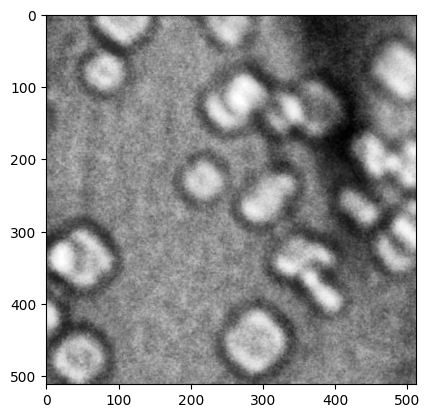

In [23]:
plt.imshow(img[0,...], cmap='gray')

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1. The prediction masks are arranged in descending order of confidence score from 0-1. The highest score being the prediction with the highest fidelity.

torch.Size([37, 1, 512, 512])
score: 0.9922036


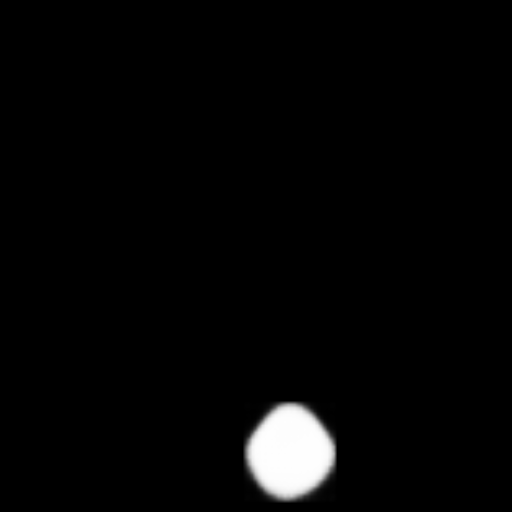

In [27]:
print(prediction[0]['masks'].shape)
# ['masks'][N, 0] where N is the number of predictions
N = 2
print('score:', prediction[0]['scores'][N].cpu().numpy())
Image.fromarray(prediction[0]['masks'][N, 0].mul(255).byte().cpu().numpy())